### Import the libraries

In [30]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
from sklearn.model_selection import train_test_split

### Define image properties

In [31]:
Image_Width = 128
Image_Height = 128
Image_Size = (Image_Width, Image_Height)
Image_Channels = 3

### Prepare dataset for training model

In [32]:
filenames = os.listdir("./datasets/train")

categories = []
for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

### Create the neural net model

In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])

### Analyzing model

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 61, 61, 64)      

### Define callbacks and learning rate

In [35]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

### Manage data

In [36]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
train_df, validate_df = train_test_split(df, test_size=0.20,
                                         random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

### Training and validation data generator

In [49]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1. / 255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                   )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    "./datasets/train/", x_col='filename', y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "./datasets/train/",
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1. / 255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

test_generator = train_datagen.flow_from_dataframe(test_df,
                                                   "./datasets/test/", x_col='filename', y_col=None,
                                                   target_size=Image_Size,
                                                   class_mode=None,
                                                   batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Model Training

In [38]:
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 159s 118ms/step - loss: 0.7312 - accuracy: 0.6452 - val_loss: 0.5453 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 160s 120ms/step - loss: 0.5472 - accuracy: 0.7311 - val_loss: 0.5038 - val_accuracy: 0.7568 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 159s 119ms/step - loss: 0.4963 - accuracy: 0.7666 - val_loss: 0.4357 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 160s 120ms/step - loss: 0.4617 - accuracy: 0.7845 - val_loss: 0.8142 - val_accuracy: 0.6773 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8032
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 157s 118ms/step - loss: 0.4389 - accuracy: 0.8032 - val_loss: 0.4687 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 6/10
1333/1333 [==========

### Save the model

In [39]:
model.save("model_catsVSdogs_10epochs.h5")

### Test data preparation

In [50]:
test_filenames = os.listdir("./datasets/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

### Make categorical prediction

In [51]:
predict = model.predict(test_generator, np.ceil(nb_samples / batch_size))

834/834 [==============================] - 60s 72ms/step


### Convert labels to categories

In [52]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({'dog': 1, 'cat': 0})

### Visualize the prediction results

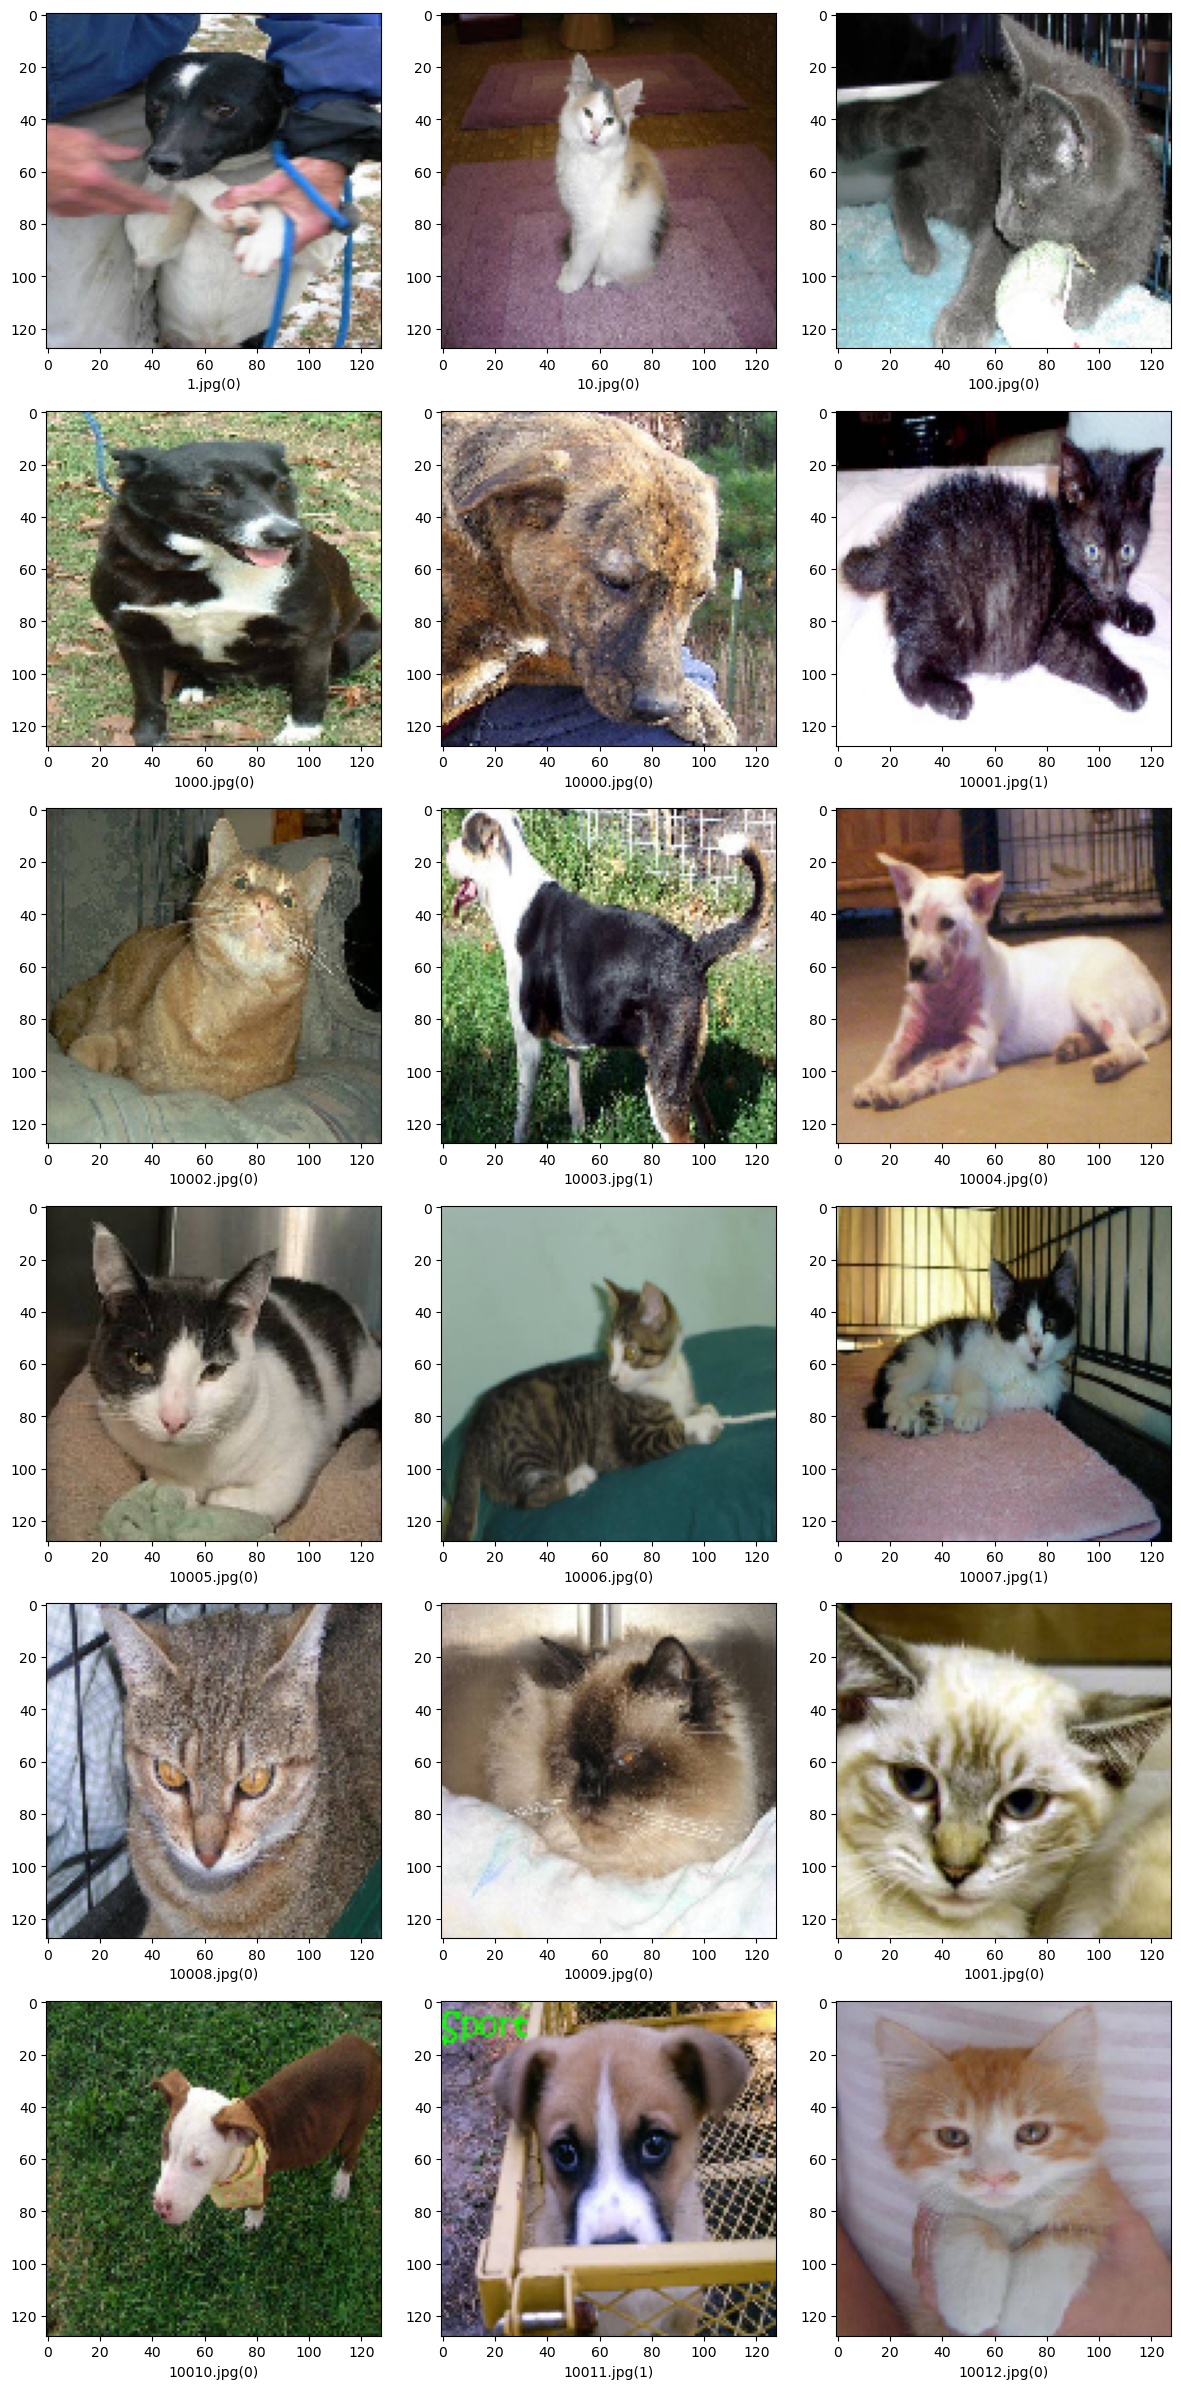

In [53]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./datasets/test/" + filename, target_size=Image_Size)
    plt.subplot(6, 3, index + 1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()